In [45]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=cfc45581e5472379e6bf56a639b0264bc9633e9f4148a688464ef3a802c95496
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [46]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy

In [32]:
fake_news = pd.read_csv('./Fake.csv')
true_news = pd.read_csv('./True.csv')

In [33]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
class Config:
  is_fake = 1
  is_true = 0 

In [35]:
fake_news['label'] = Config.is_fake
true_news['label'] = Config.is_true

In [36]:
df = pd.concat([fake_news, true_news], ignore_index=True)
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [37]:
df['full_text'] = df['title'] + df['text']
df.head()

,title,text,subject,date,label,full_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...


In [38]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [40]:
df['subject'].replace({
    'politicsNews': 'PoliticsNews',
    'politics': 'PoliticsNews',
    'worldnews': 'Worldnews',
    'left-news': 'Left-news'
}, inplace=True)
df['subject'].value_counts()

PoliticsNews       18113
Worldnews          10145
News                9050
Left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [41]:
df.isnull().sum()

title        0
text         0
subject      0
date         0
label        0
full_text    0
dtype: int64

In [43]:
df[['subject', 'label']].value_counts(normalize=True)

subject          label
PoliticsNews     0        0.251058
Worldnews        0        0.225957
News             1        0.201568
PoliticsNews     1        0.152368
Left-news        1        0.099314
Government News  1        0.034968
US_News          1        0.017440
Middle-east      1        0.017328
dtype: float64

In [52]:
nltk.download('punkt')

def light_preprocess(input, join=True):
  if isinstance(input, str):
    input = " ".join(tokenize.sent_tokenize(input))
    for symb in ["!", ",", ":", ";", "?"]:
        input = re.sub(rf"\{symb}\.", symb, input)
    input = re.sub("[^a-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}]+", " ", input)
    input = input.strip()
    input = input.lower()
  return input

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
df['light_cleaned_full_text'] = df['full_text'].apply(lambda x: light_preprocess(x))
df['light_cleaned_full_text'].head()

0    donald trump sends out embarrassing new year s...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obama s name ...
4    pope francis just called out donald trump duri...
Name: light_cleaned_full_text, dtype: object

In [54]:
nltk.download('stopwords')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def hard_preprocess(text, join_back=True):
    result = []
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        result.extend(filtered_words)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
df['hard_cleaned_full_text'] = df['full_text'].apply(lambda x: hard_preprocess(x))
df['hard_cleaned_full_text'].head()

0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama name coded website i...
4    pope francis called donald trump christmas spe...
Name: hard_cleaned_full_text, dtype: object

In [57]:
idx = 100

print(
    f"Before : {df['full_text'].iloc[idx]}\n"
    f"After light : {df['light_cleaned_full_text'].iloc[idx]}\n"
    f"After hard : {df['hard_cleaned_full_text'].iloc[idx]}"
)

Before :  Watch: Joe Biden Just Wrecked Trump In Six Words And It’s HilariousFormer Vice President Joe Biden was asked on Monday by Matt Lauer on NBC s  Today  to name something specific that Donald Trump has been  doing well. Well, that seems like a trick question since Trump has passed no major legislation and reaches across the aisle only to take shots at Democrats in his Twitter timeline during his morning rage-tweets, so Biden struggled to find something, anything, that Trump has done well since taking office. I think there s a number of things he s doing well. But even the things he s doing well, it s how he does them,  Biden said. It s more the tone of this administration that bothers me,  he continued. With all due respect, you haven t come up with one thing you think he s doing well,  Lauer said. Well, I think he married very well,  Biden joked.Although, Biden didn t mention which of Trump s three marriages he s speaking of. Trump s first marriage to Ivana ended after he had a

In [68]:
y = pd.DataFrame(df['label'], columns=['label'])
X = df.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

,title,text,subject,date,full_text,light_cleaned_full_text,hard_cleaned_full_text
36335,Turkey's Erdogan says U.S. Jerusalem decision ...,ATHENS (Reuters) - Turkish President Tayyip Er...,Worldnews,"December 7, 2017",Turkey's Erdogan says U.S. Jerusalem decision ...,turkey's erdogan says u.s. jerusalem decision ...,turkey erdogan says jerusalem decision trample...
12384,BREAKING: Trump Reportedly Considering Ted Cru...,"Ted Cruz would be fair, honest and most of all...",PoliticsNews,"Nov 15, 2016",BREAKING: Trump Reportedly Considering Ted Cru...,breaking: trump reportedly considering ted cru...,breaking trump reportedly considering ted cruz...
24419,Trump chief of staff's Civil War comment spark...,WASHINGTON (Reuters) - White House Chief of St...,PoliticsNews,"October 31, 2017",Trump chief of staff's Civil War comment spark...,trump chief of staff's civil war comment spark...,trump chief staff civil war comment sparks cri...
24740,Saudi Arabia welcomes new U.S. strategy toward...,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,PoliticsNews,"October 13, 2017",Saudi Arabia welcomes new U.S. strategy toward...,saudi arabia welcomes new u.s. strategy toward...,saudi arabia welcomes new strategy toward iran...
27039,Trump arrives in Sicily ahead of Group of Seve...,"SIGONELLA, Italy (Reuters) - U.S. President Do...",PoliticsNews,"May 25, 2017",Trump arrives in Sicily ahead of Group of Seve...,trump arrives in sicily ahead of group of seve...,trump arrives sicily ahead group seven summits...


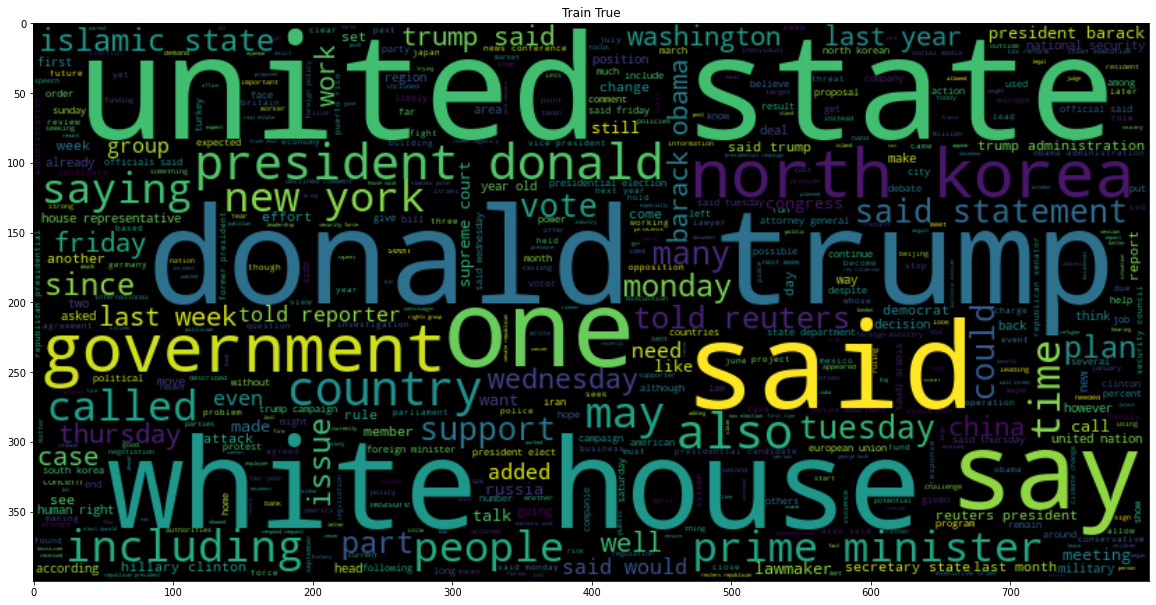

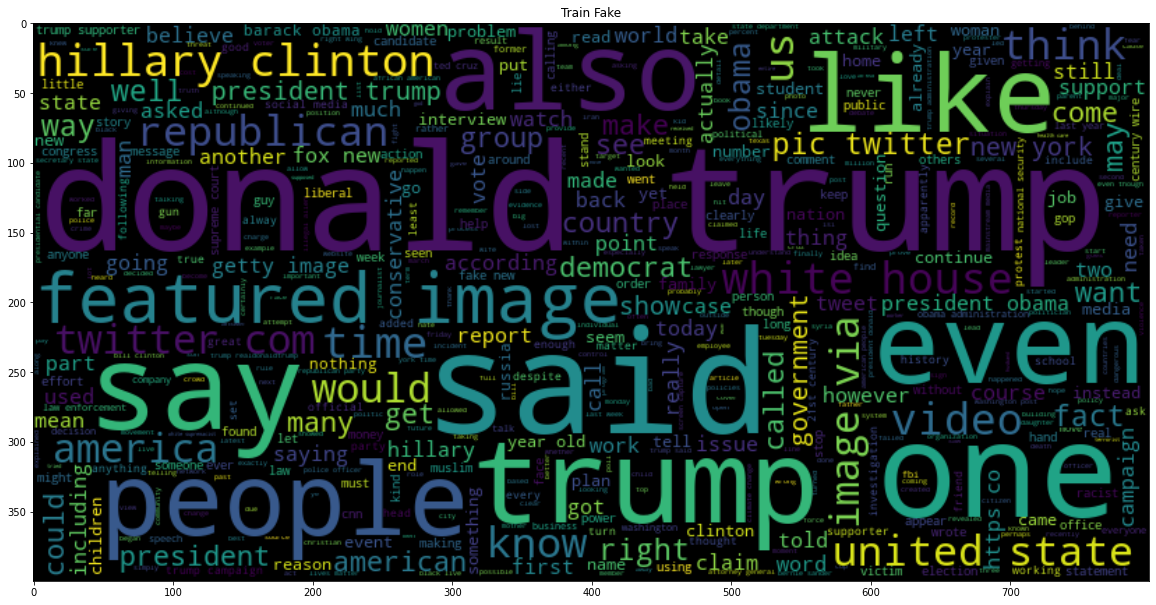

In [71]:
plt.figure(figsize = (20,20)) 
plt.title("Train True")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(X_train.loc[y_train['label'] == Config.is_true, 'hard_cleaned_full_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train Fake")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(X_train.loc[y_train['label'] == Config.is_fake, 'hard_cleaned_full_text']))
plt.imshow(wc, interpolation = 'bilinear')

In [98]:
def comp_metric(y_true, y_pred, verbose=True):
    print(y_true.shape)
    print(y_pred.shape)
    assert y_true.shape == y_pred.shape
    result = roc_auc_score(y_true, y_pred)
    if verbose:
        print(f"Result Roc Auc: {result}")
    return result

In [87]:
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('log_reg', LogisticRegression())
])
all_train_pred = model.fit(
    X_train['full_text'],
    y_train
).predict_proba(X_train['full_text'])
all_train_pred = np.stack([el[1] for el in all_train_pred])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
comp_metric(y_train.squeeze(1), all_train_pred)

Result Roc Auc: 1.0


1.0

In [93]:
# check prediction for test dataset
all_train_pred = model.fit(
    X_train['full_text'],
    y_train
).predict_proba(X_test['full_text'])
all_train_pred = np.stack([el[1] for el in all_train_pred])
comp_metric(y_test.squeeze(1), all_train_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Result Roc Auc: 0.9987033513819751


0.9987033513819751

In [104]:
class Model:
  def __init__(self):
    pass

  def pick_model(self, option):
    if option == 'log':
      return LogisticRegression()
    raise ValueError('Not supported model.')

  def pick_vectorizer(self, name):
    if name == 'count':
      return CountVectorizer()
    elif name == 'tfidf':
      return TfidfVectorizer()
    raise ValueError('Not supported vectorizer.')

  def create_pipeline(self, vectorizer_name='count', option='log'):
    model = self.pick_model(option)
    vectorizer = self.pick_vectorizer(vectorizer_name)
    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("model", model)
    ])
    return pipeline

In [95]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(X_train, y_train)]

In [106]:
from sklearn.model_selection import GridSearchCV

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []

model = Model()

for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    parameters = {
        'model__C': [.01, .1, 1, 10],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    }
    pipeline = model.create_pipeline()

    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters)
    grid.fit(X_train["full_text"].iloc[train_ids], y_train.iloc[train_ids])
    fold_train_preds = grid.predict_proba(X_train["full_text"].iloc[train_ids])
    fold_train_preds = np.stack([el[1] for el in fold_train_preds])
    fold_test_preds = grid.predict_proba(X_train["full_text"].iloc[test_ids])
    fold_test_preds = np.stack([el[1] for el in fold_test_preds])
    fold_train_targets = y_train.iloc[train_ids].values
    fold_test_targets = y_train.iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets.squeeze(1), fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets.squeeze(1), fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(grid)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 0
Train: 
(28734,)
(28734,)
Result Roc Auc: 1.0
Test: 
(7184,)
(7184,)
Result Roc Auc: 0.9994922151038632


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1
Train: 
(28734,)
(28734,)
Result Roc Auc: 1.0
Test: 
(7184,)
(7184,)
Result Roc Auc: 0.9987763541059987


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2
Train: 
(28734,)
(28734,)
Result Roc Auc: 1.0
Test: 
(7184,)
(7184,)
Result Roc Auc: 0.9995788778877888


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3
Train: 
(28735,)
(28735,)
Result Roc Auc: 1.0
Test: 
(7183,)
(7183,)
Result Roc Auc: 0.9990584171309981


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4
Train: 
(28735,)
(28735,)
Result Roc Auc: 1.0
Test: 
(7183,)
(7183,)
Result Roc Auc: 0.9990079280314393


In [107]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train: ")
comp_metric(all_train_targets.squeeze(1), all_train_preds);
print("OOF Test: ")
comp_metric(all_test_targets.squeeze(1), all_test_preds);

OOF Train: 
(143672,)
(143672,)
Result Roc Auc: 1.0
OOF Test: 
(35918,)
(35918,)
Result Roc Auc: 0.9991809679656454


# Algorithm implementation with SentenceTransoformer

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2', device=device)
X_train['encoded_full_text'] = sent_tr.encode(X_train['full_text'].to_list())
X_train['encoded_full_text'].head()


In [ ]:
params = {
    'penalty': ['l2'],
    'C': [.01, .1, 1, 10]
}

vectorizer = StandardScaler() # TfidfVectorizer()

grid = GridSearchCV(LogisticRegression(random_state=42),
                    param_grid=params,
                    scoring='roc_auc',
                    n_jobs=-1, error_score='raise', return_train_score=True
)

grid.fit(vectorizer.fit_tranform(X_train['encoded_full_text'], y_train))


In [ ]:
pred = model.predict_proba(vectorizer.transform(X_test['encoded_full_text']))[:, 1]
pred.head()

In [ ]:
score = roc_auc_score(pred, y_test)
print(f'ROC AUC score: {score}')